# Conformal Toy Regression


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm.notebook import tqdm


# torch.set_default_dtype(torch.float64)
N_BOUND = -30 if torch.get_default_dtype() == torch.float64 else -20
DTYPE = torch.get_default_dtype()

In [2]:
FONTSIZE = 18

# Try LaTeX settings, fall back gracefully
try:
    if shutil.which("latex") is not None:
        plt.rc("text", usetex=True)
        plt.rc(
            "text.latex",
            preamble=r"\usepackage{amsmath}\usepackage[bitstream-charter]{mathdesign}",
        )
        plt.rc("font", family="serif", size=FONTSIZE, serif="Charter")
    else:
        raise RuntimeError("LaTeX not found")
except Exception:
    # Fallback to default matplotlib serif font
    plt.rc("text", usetex=False)
    plt.rc("font", family="serif", size=FONTSIZE)

plt.rc("axes", titlesize="medium")

# Define color cycle
colors = [f"C{i}" for i in range(5)]

In [3]:
# Get some simple toy function
def generate_data(n_samples, unc=0.2, seed=None):
    """
    Simple 1D regression problem based
    """
    if seed is not None:
        np.random.seed(seed)
    x = np.concatenate(
        (
            np.random.uniform(-1, -0.22, n_samples // 2),
            np.random.uniform(0.22, 1, n_samples - n_samples // 2),
        )
    )
    y = 0.5 * np.sin(23 * x) + x / 2
    y_noise = (
        y + np.random.randn(n_samples) * unc
    )  # * (x+1) + np.random.randn(n_samples) * unc/2
    return x, y_noise

In [4]:
def conformal_prediction(model, x_cal, y_cal, x_pred, alpha=0.05):
    # via https://www.stat.berkeley.edu/~ryantibs/statlearn-s23/lectures/conformal.pdf
    with torch.inference_mode():
        pred = model(x_cal)
        residual = torch.abs(pred - y_cal).squeeze()
        n_cal = len(residual)
        q_level = np.ceil((1 - alpha) * (1 + n_cal)) / n_cal
        q_hat = torch.quantile(residual, q_level)

        y_hat = model(x_pred)
        return (y_hat - q_hat).flatten(), (y_hat + q_hat).flatten()

In [5]:
class Net(nn.Module):
    def __init__(
        self, hdn_dim: int = 14, n_layers: int = 2, hetero: bool = False
    ) -> None:
        super().__init__()

        assert n_layers > 1
        self.layers = []
        self.layers.append(nn.Linear(1, hdn_dim))
        for i in range(n_layers - 1):
            self.layers.append(nn.GELU())
            if i == n_layers - 2:
                self.layers.append(nn.Linear(hdn_dim, 2 if hetero else 1))
            else:
                self.layers.append(nn.Linear(hdn_dim, hdn_dim))

        self.net = nn.Sequential(*self.layers)

        self._hetero = hetero

    def loss(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        if self._hetero:
            mean = pred[:, 0]
            lvar = pred[:, 1].clamp(N_BOUND, 11)
            nll = 0.5 * ((target - mean) ** 2 / lvar + lvar)
        else:
            nll = torch.mean((target - pred).pow(2))  # unnormalized
        return torch.mean(nll)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [6]:
# define training setup
epochs = 1000
batch_size = 200
n_samples = (
    batch_size * 9
)  # 10 for the other examples, as they don't need to consider a conformal set
unc = 0.1
seed = 42

# get reproducible datapoints
x_train, y_train = generate_data(n_samples, unc=unc, seed=seed)
x_cal, y_cal = generate_data(batch_size, unc=unc, seed=seed + 23)
x_cal = torch.tensor(x_cal[:, None], dtype=DTYPE)
y_cal = torch.tensor(y_cal[:, None], dtype=DTYPE)

# Fit scaler and save the mean and std to undo
# scaling later
Y_STD = y_train.std()
Y_MEAN = y_train.mean()
y_train_scaled = (y_train - Y_MEAN) / Y_STD

y_cal = (y_cal - Y_MEAN) / Y_STD

# Define the model and look at it
trn_len = x_train.shape[0]
hdn_dim = 32
layers = 6  # number of hidden layers
toy_model = Net(hdn_dim=hdn_dim, n_layers=layers)


# Build dataset
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_train[:, None], dtype=DTYPE),
    torch.tensor(y_train_scaled, dtype=DTYPE),
)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

opt = torch.optim.AdamW(toy_model.parameters(), lr=5e-3)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs * len(loader))

print(toy_model)

Net(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [7]:
# Train the model
toy_model.train()

for i in tqdm(range(epochs)):
    train_losses = np.array([])
    for xb, yb in loader:

        # pass data through network
        pred = toy_model(xb)

        # compute loss
        loss = toy_model.loss(pred, yb.unsqueeze(-1))

        train_losses = np.append(train_losses, loss.item())

        # reset gradients in optimizer
        opt.zero_grad()

        # compute gradients
        loss.backward()

        # update weights with optimizer
        opt.step()
        sched.step()

    train_losses_epoch = train_losses.mean()

    if i % 50 == 0:
        tqdm.write(f"epoch={i}, loss={train_losses_epoch:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch=0, loss=0.9287
epoch=50, loss=0.5059
epoch=100, loss=0.1320
epoch=150, loss=0.0478
epoch=200, loss=0.0430
epoch=250, loss=0.0410
epoch=300, loss=0.0410
epoch=350, loss=0.0436
epoch=400, loss=0.0422
epoch=450, loss=0.0407
epoch=500, loss=0.0410
epoch=550, loss=0.0399
epoch=600, loss=0.0404
epoch=650, loss=0.0404
epoch=700, loss=0.0394
epoch=750, loss=0.0397
epoch=800, loss=0.0387
epoch=850, loss=0.0385
epoch=900, loss=0.0384
epoch=950, loss=0.0383


In [8]:
xx = torch.linspace(-1.2, 1.2, 5000).unsqueeze(-1)
toy_model.eval()

rescale = lambda x, mean, std: x * std + mean

with torch.inference_mode():
    pred = rescale(toy_model(xx), Y_MEAN, Y_STD)

/var/folders/tk/jsn2pd3x4qb48x1705r8jc_80000gn/T/ipykernel_24698/476188937.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = 0.5 * np.sin(23*xx) + xx/2


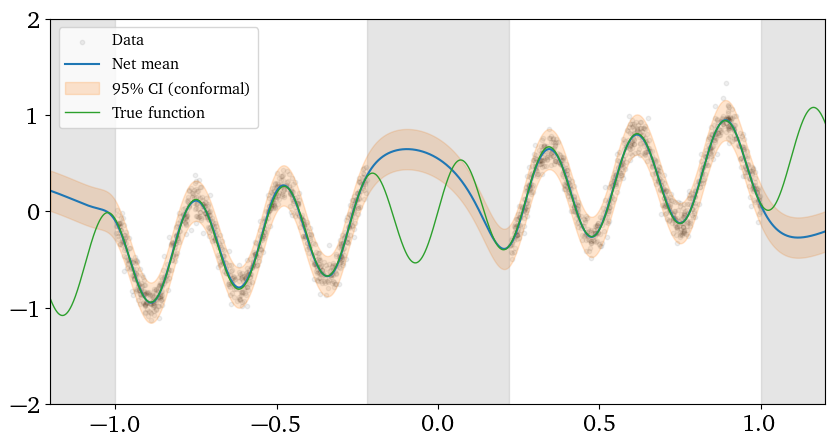

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, s=10, alpha=1 / 16, label="Data", color="k")
plt.plot(xx, pred, color="C0", label="Net mean")
lower_ci, upper_ci = conformal_prediction(toy_model, x_cal, y_cal, xx, alpha=0.05)
lower_ci = rescale(lower_ci, Y_MEAN, Y_STD)
upper_ci = rescale(upper_ci, Y_MEAN, Y_STD)
plt.fill_between(
    xx.flatten(),
    lower_ci.flatten(),
    upper_ci.flatten(),
    alpha=0.2,
    label=r"95\% CI (conformal)",
    color="C1",
)
plt.axvspan(-0.22, 0.22, color="gray", alpha=0.2)
plt.axvspan(1, 1.2, color="gray", alpha=0.2)
plt.axvspan(-1.2, -1.0, color="gray", alpha=0.2)
y = 0.5 * np.sin(23 * xx) + xx / 2
plt.plot(xx, y, color="C2", label="True function", linewidth=1)
plt.legend(fontsize=FONTSIZE - 6, loc="upper left")
plt.ylim(-2, 2)
plt.xlim(-1.2, 1.2)
plt.show()

In [10]:
lower, upper = conformal_prediction(toy_model, x_cal, y_cal, xx, alpha=0.05)